### Leonard Molano  |  Group 6  |   September 5, 2020

### Term Deposit Sale
Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image  
from sklearn import tree
from os import system
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import ClassificationReport, ROCAUC
from sklearn.linear_model import LogisticRegression

In [3]:
bank = pd.read_csv("bank-full.csv")

In [4]:
# Dropping duration since note on data specifies it should be only used when performing benchmarks
bank = bank.drop('duration', axis =1 ) 

In [5]:
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [6]:
bank.shape

(45211, 16)

In [7]:
bank['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [8]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

In [9]:
bank.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
campaign       48
pdays         559
previous       41
poutcome        4
Target          2
dtype: int64

## Univariate analysis
a. Univariate analysis – data types and description of the independent attributes which should include (name, meaning, range of values observed, central values (mean and median), standard deviation and quartiles, analysis of the body of distributions / tails, missing values, outliers.

b. Strategies to address the different data challenges such as data pollution, outlier’s treatment and missing values treatment.

c. Please provide comments in jupyter notebook regarding the steps you take and insights drawn from the plots.

In [10]:
bank.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [11]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

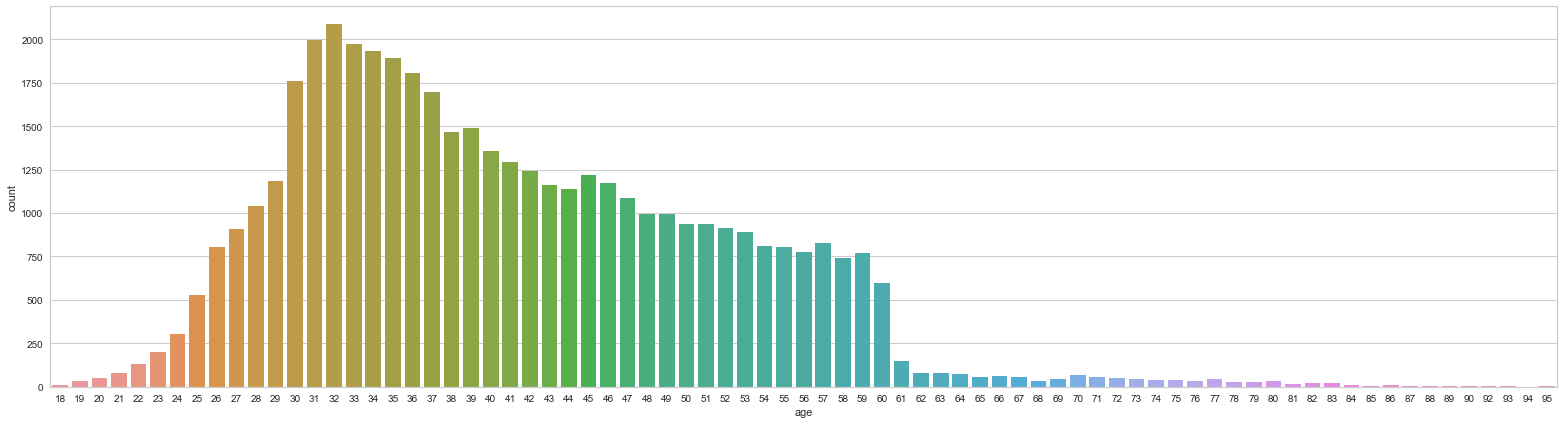

In [12]:
fig = plt.gcf()
fig.set_size_inches(27, 7)
sns.countplot(bank['age'])

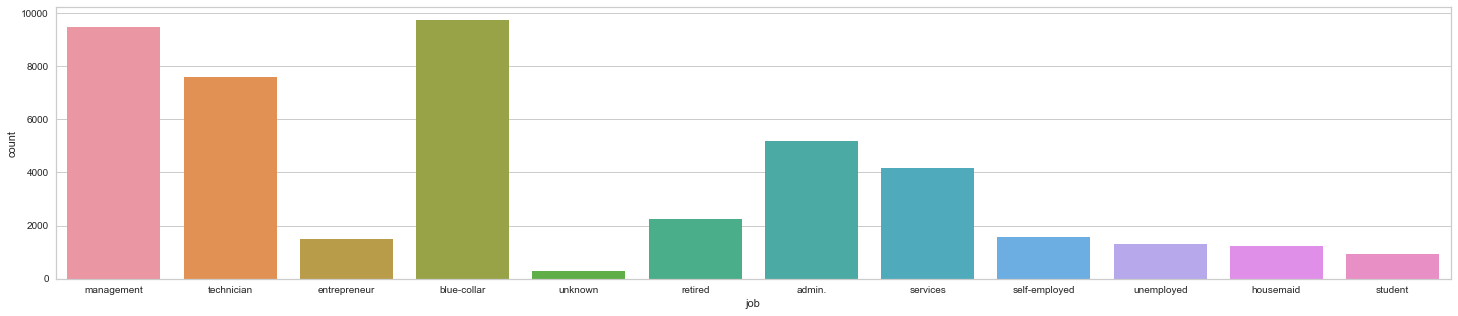

In [13]:
fig = plt.gcf()
fig.set_size_inches(25, 5)
sns.countplot(bank['job'])

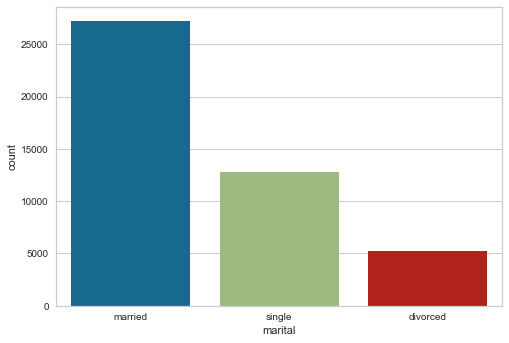

In [14]:
sns.countplot(bank['marital'])

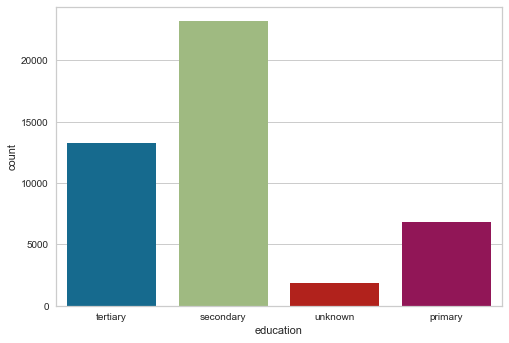

In [15]:
sns.countplot(bank['education'])

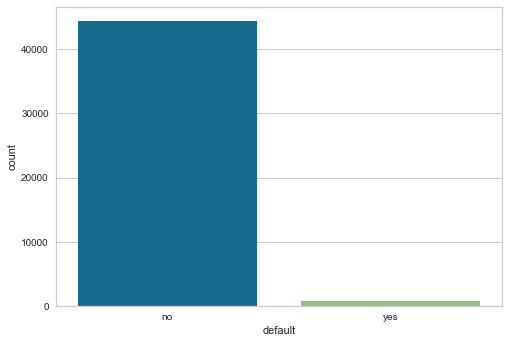

In [16]:
sns.countplot(bank['default'])

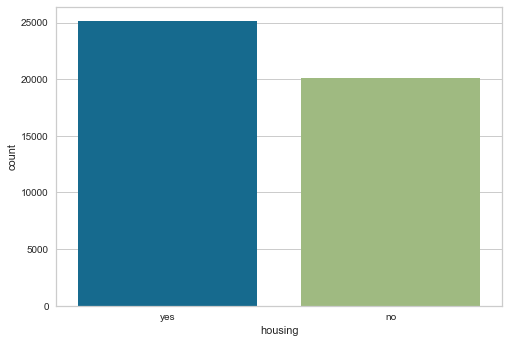

In [17]:
sns.countplot(bank['housing'])

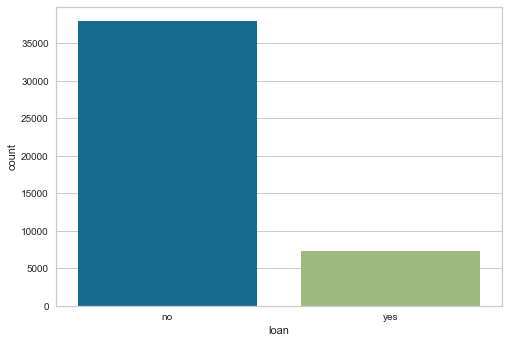

In [18]:
sns.countplot(bank['loan'])

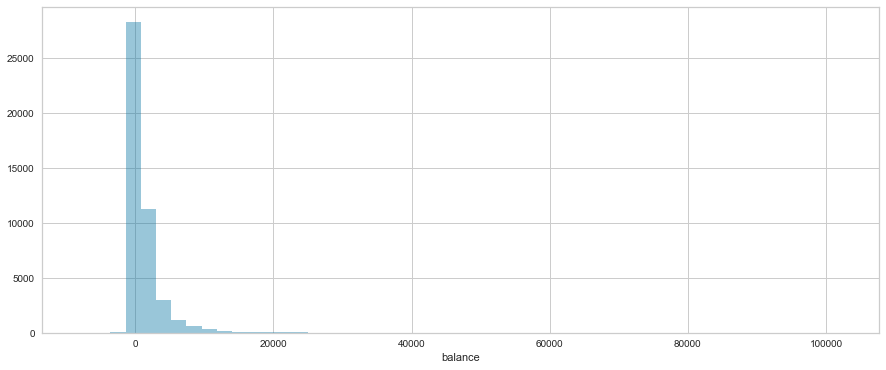

In [19]:
fig = plt.gcf()
fig.set_size_inches(15, 6)
sns.distplot(bank['balance'], kde=False, rug=False);

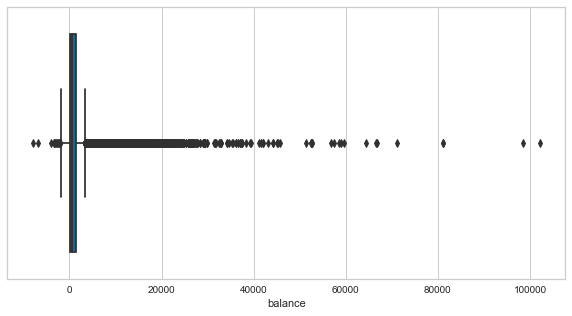

In [20]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.boxplot(bank['balance'])

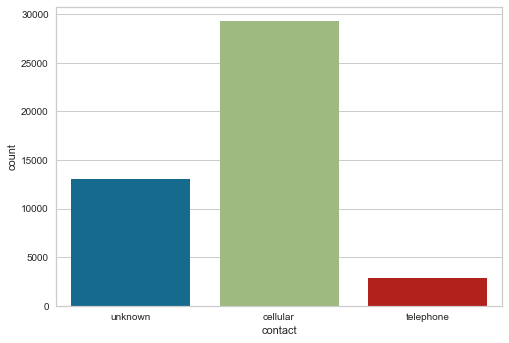

In [21]:
sns.countplot(bank['contact'])

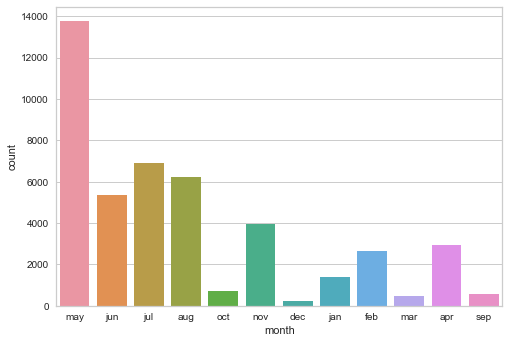

In [22]:
sns.countplot(bank['month'])

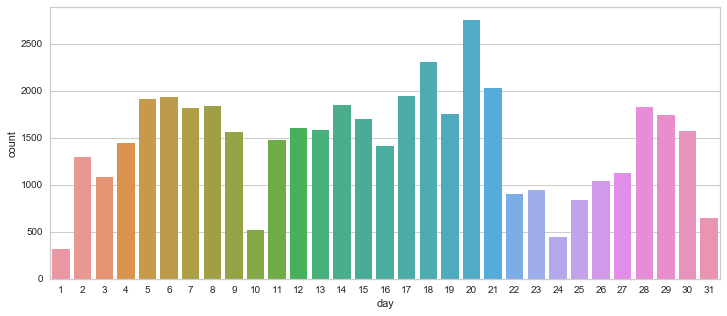

In [23]:
fig = plt.gcf()
fig.set_size_inches(12, 5)
sns.countplot(bank['day'])

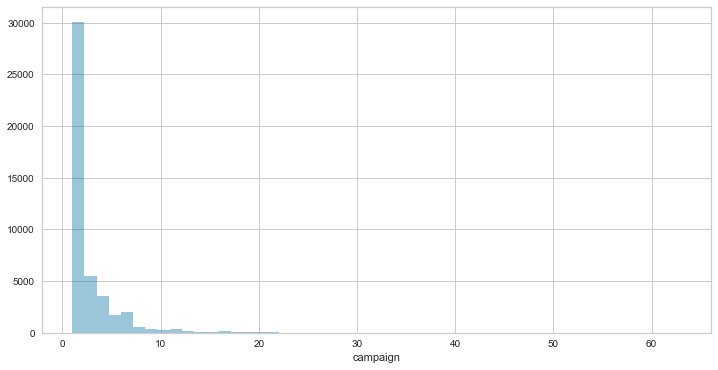

In [24]:
fig = plt.gcf()
fig.set_size_inches(12, 6)
sns.distplot(bank['campaign'], kde=False);

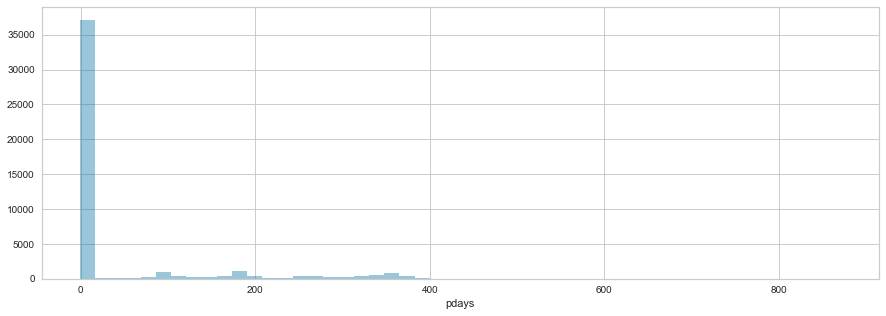

In [25]:
fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.distplot(bank['pdays'], kde=False);

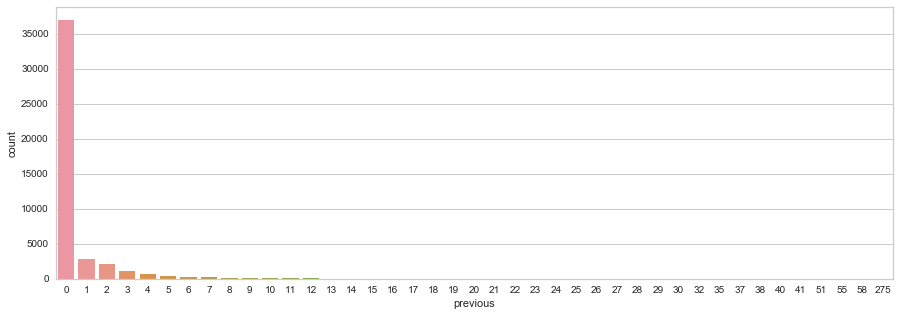

In [26]:
fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.countplot(bank['previous']);

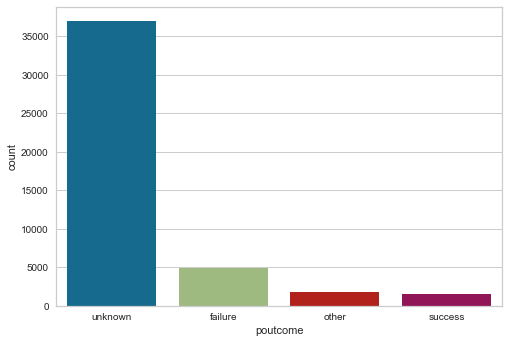

In [27]:
sns.countplot(bank['poutcome'])

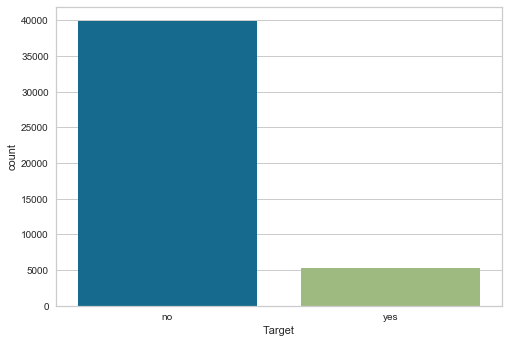

In [28]:
sns.countplot(bank['Target'])

## Comments from univariate analysis

At first glance no variable has any null entries in them and no entries were eliminated because of this.

Some variables have a pretty high ammount of 'unknown' or '-1' entries, such as 'outcome', 'contact', 'previous' and 'pdays'. If these variables end up being highly relevant when entering the model then they could potentially become an issues. For the time being we will not get rid of these datapoints.

'Balance'is the only continous field in the dataset and has a wide range of values in them. We will need to normalize the set so our model will perform better. Most other fields are categorical, no need to normalize their results, or elminiate any potential outliers

Regarding the Target variable, the main focus of this research, it has a pretty high ammount of 'no' results in them, which could potentially affect the accuracy of how our model predicting true positive cases. Nonetheless it was expected since these types of studies have a high amount of 'no' entries in them due to human behaviour.


In [29]:
# Normalize variables
cols_to_norm = ['balance']
bank[cols_to_norm] = bank[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

## Multivariate analysis

In [30]:
bank_view = bank.copy()

In [31]:
from sklearn import preprocessing
le = LabelEncoder()

bank_view['default'] = le.fit_transform(bank_view['default'])
bank_view['loan']    = le.fit_transform(bank_view['loan'])
bank_view['Target']  = le.fit_transform(bank_view['Target'])
bank_view['month'] = le.fit_transform(bank_view['month'])
bank_view['job'] = le.fit_transform(bank_view['job'])
bank_view['marital'] = le.fit_transform(bank_view['marital'])
bank_view['education'] = le.fit_transform(bank_view['education'])
bank_view['housing'] = le.fit_transform(bank_view['housing'])
bank_view['contact'] = le.fit_transform(bank_view['contact'])
bank_view['poutcome'] = le.fit_transform(bank_view['poutcome'])

In [32]:
bank_view.dtypes

age            int64
job            int64
marital        int64
education      int64
default        int64
balance      float64
housing        int64
loan           int64
contact        int64
day            int64
month          int64
campaign       int64
pdays          int64
previous       int64
poutcome       int64
Target         int64
dtype: object

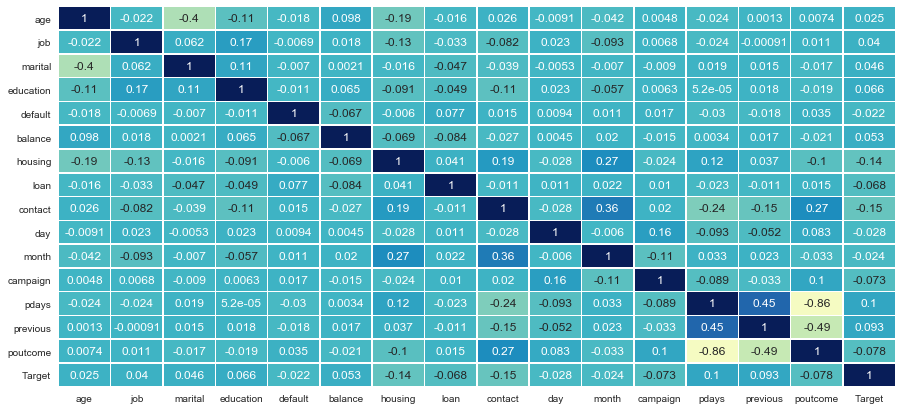

In [33]:
plt.figure(figsize=(15,7))
sns.heatmap(bank_view.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

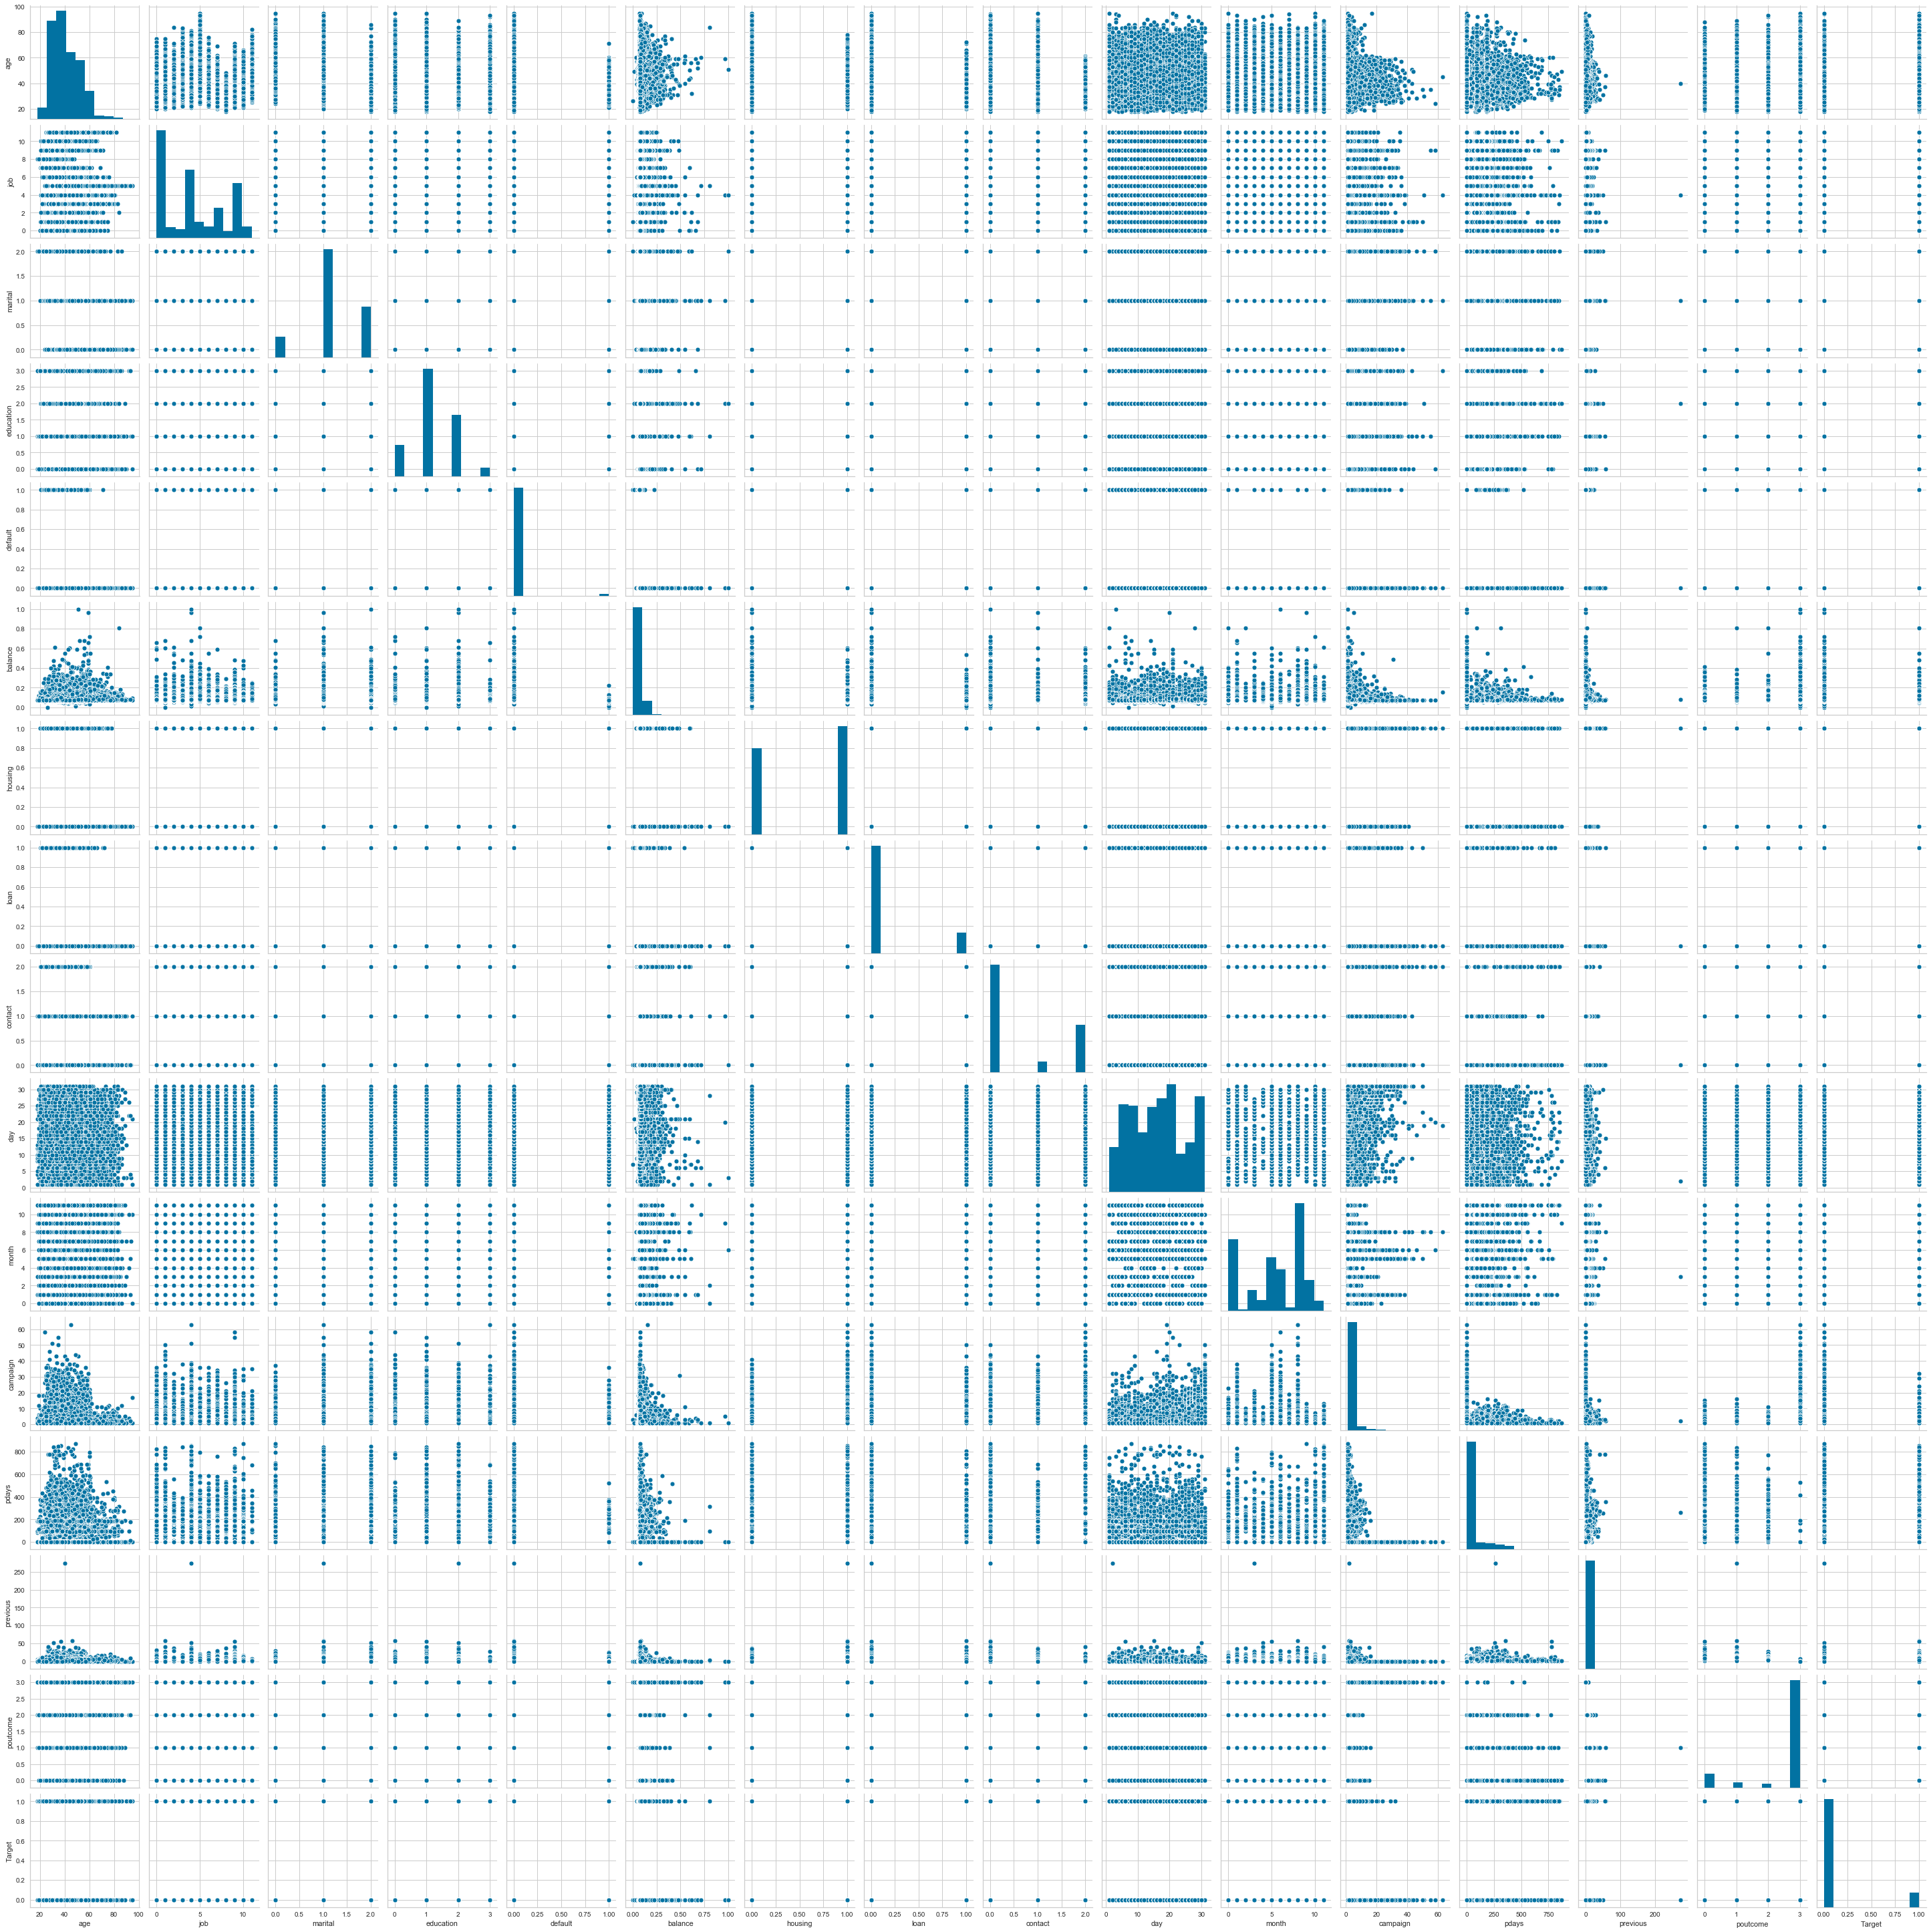

In [34]:
sns.pairplot(bank_view)

## Comments on Multivariate analysis
To first analyze the data we convert all categorical fields to numerical for better visualization. 

We first see in the correlation heatmap that Target doesn't really have a strong correlation with any of the other variable. This makes it harder for us to identify what would be a good starting point when further analysing the data.

The histogram matrix also tells a similar story in where there are no inmidiate variable that show a high correlation with 'Target'. 

## Format data for better processing

In [35]:
bank_model = bank.copy()

In [36]:
oneHotCols = ['job', 'marital', 'education', 'contact', 'poutcome']
bank_model = pd.get_dummies(bank_model, columns=oneHotCols)

In [37]:
le = LabelEncoder()

bank_model['default'] = le.fit_transform(bank_model['default'])
bank_model['housing'] = le.fit_transform(bank_model['housing'])
bank_model['loan']    = le.fit_transform(bank_model['loan'])
bank_model['month'] = le.fit_transform(bank_model['month'])
bank_model['Target']  = le.fit_transform(bank_model['Target'])

In [38]:
bank_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45211 non-null  int64  
 1   default              45211 non-null  int64  
 2   balance              45211 non-null  float64
 3   housing              45211 non-null  int64  
 4   loan                 45211 non-null  int64  
 5   day                  45211 non-null  int64  
 6   month                45211 non-null  int64  
 7   campaign             45211 non-null  int64  
 8   pdays                45211 non-null  int64  
 9   previous             45211 non-null  int64  
 10  Target               45211 non-null  int64  
 11  job_admin.           45211 non-null  uint8  
 12  job_blue-collar      45211 non-null  uint8  
 13  job_entrepreneur     45211 non-null  uint8  
 14  job_housemaid        45211 non-null  uint8  
 15  job_management       45211 non-null 

## Split Data

In [39]:
X = bank_model.drop(['Target'], axis=1)
Y = bank_model['Target']

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) 

## Logistic Regression

In [41]:
log_model = LogisticRegression(solver="liblinear")
log_model.fit(X_train, np.ravel(Y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
LogisticRegression = [
    'LogisticRegression', 
    accuracy_score(Y_test, log_model.predict(X_test)),
    precision_score(Y_test, log_model.predict(X_test)),
    recall_score(Y_test, log_model.predict(X_test)),
    f1_score(Y_test, log_model.predict(X_test))
]

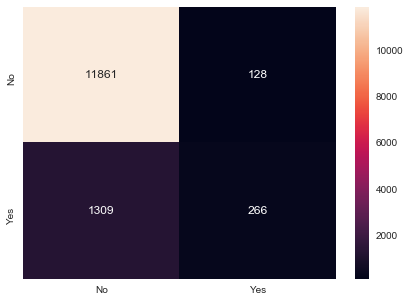

In [43]:
Y_predict = log_model.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])

plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

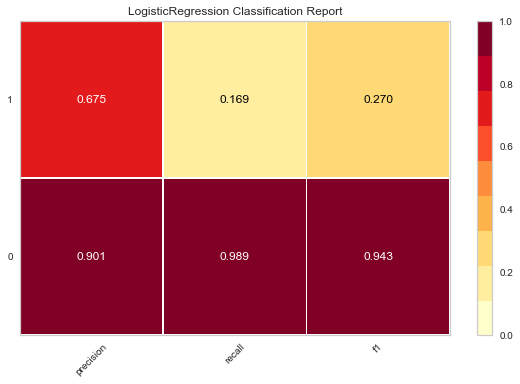

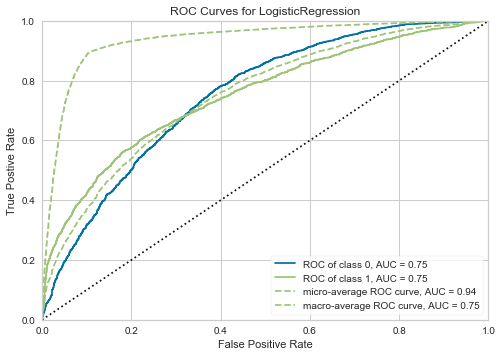

In [44]:
viz = ClassificationReport(log_model)
viz.fit(X_train, Y_train)
viz.score(X_test, Y_test)
viz.show()

roc = ROCAUC(log_model)
roc.fit(X_train, Y_train)
roc.score(X_test, Y_test)
roc.show()

## Descision Tree

In [45]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [46]:
Tree = [
    'DecisionTree', 
    accuracy_score(Y_test, dTree.predict(X_test)),
    precision_score(Y_test, dTree.predict(X_test)),
    recall_score(Y_test, dTree.predict(X_test)),
    f1_score(Y_test, dTree.predict(X_test))
]

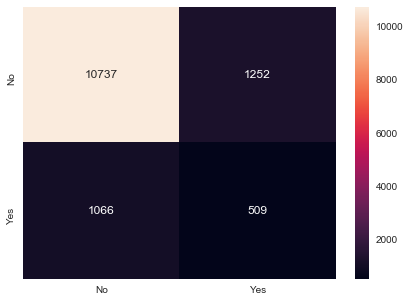

In [47]:
Y_predict = dTree.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])

plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

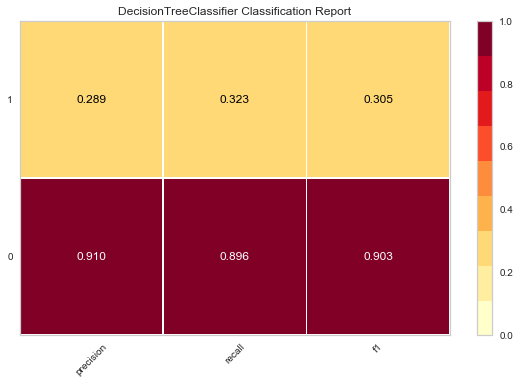

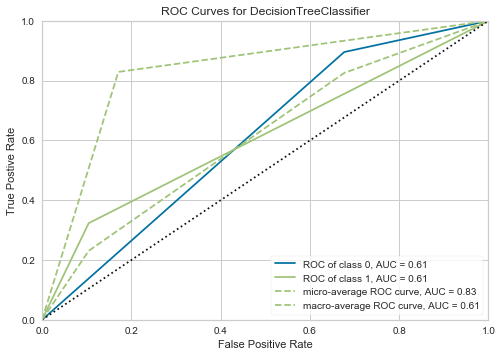

In [48]:
viz = ClassificationReport(dTree)
viz.fit(X_train, Y_train)
viz.score(X_test, Y_test)
viz.show()

roc = ROCAUC(dTree)
roc.fit(X_train, Y_train)
roc.score(X_test, Y_test)
roc.show()

## Bagging

In [49]:
bgcl = BaggingClassifier(base_estimator=dTree, n_estimators=50, random_state=1)
bgcl = bgcl.fit(X_train, Y_train)

In [50]:
Bagging = [
    'Bagging', 
    accuracy_score(Y_test, bgcl.predict(X_test)),
    precision_score(Y_test, bgcl.predict(X_test)),
    recall_score(Y_test, bgcl.predict(X_test)),
    f1_score(Y_test, bgcl.predict(X_test))   
]

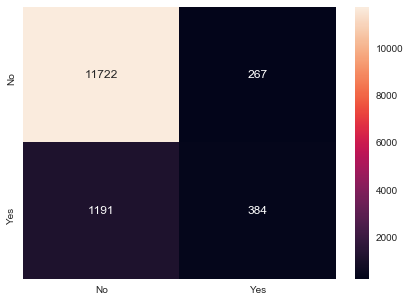

In [51]:
Y_predict = bgcl.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],                  
                     columns = [i for i in ["No","Yes"]])

plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

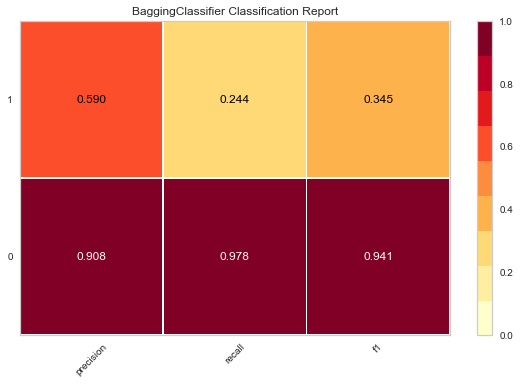

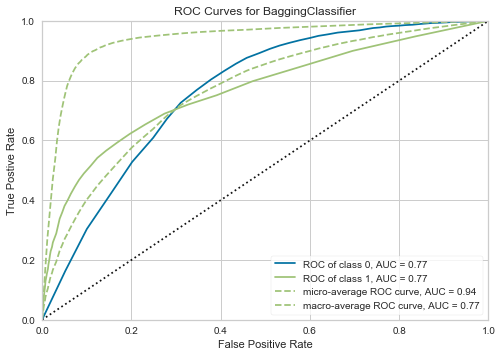

In [52]:
viz = ClassificationReport(bgcl)
viz.fit(X_train, Y_train)
viz.score(X_test, Y_test)
viz.show()

roc = ROCAUC(bgcl)
roc.fit(X_train, Y_train)
roc.score(X_test, Y_test)
roc.show()

## AdaBoosting

In [53]:
abcl = AdaBoostClassifier(n_estimators=10, random_state=1)
abcl = abcl.fit(X_train, Y_train)

In [54]:
AdaBoost = [
    'AdaBoost',
    accuracy_score(Y_test, abcl.predict(X_test)),
    precision_score(Y_test, abcl.predict(X_test)),
    recall_score(Y_test, abcl.predict(X_test)),
    f1_score(Y_test, abcl.predict(X_test))
]

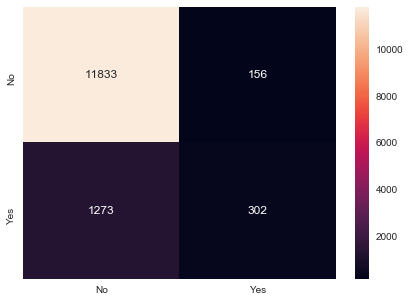

In [55]:
Y_predict = abcl.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])

plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

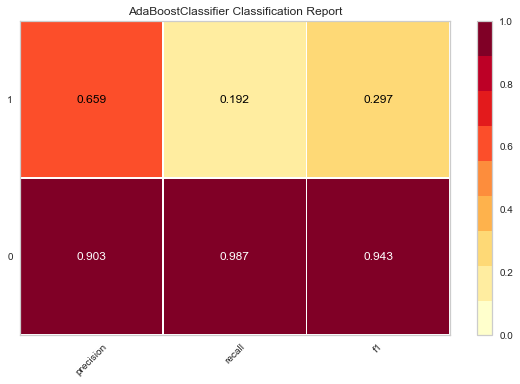

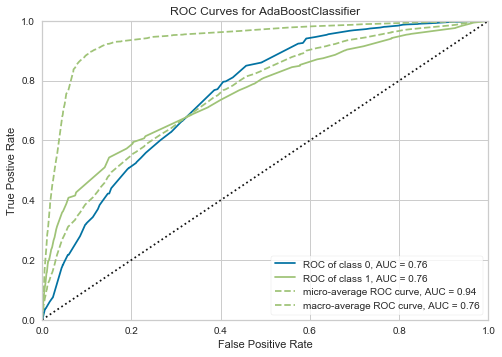

In [56]:
viz = ClassificationReport(abcl)
viz.fit(X_train, Y_train)
viz.score(X_test, Y_test)
viz.show()

roc = ROCAUC(abcl)
roc.fit(X_train, Y_train)
roc.score(X_test, Y_test)
roc.show()

## GradientBoost

In [57]:
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
gbcl = gbcl.fit(X_train, Y_train)

In [58]:
GradientBoost = [
    'GradientBoost',
    accuracy_score(Y_test, gbcl.predict(X_test)),
    precision_score(Y_test, gbcl.predict(X_test)),
    recall_score(Y_test, gbcl.predict(X_test)),
    f1_score(Y_test, gbcl.predict(X_test))
]

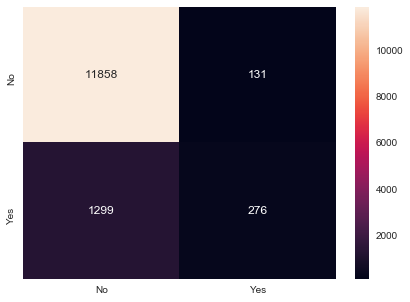

In [59]:
Y_predict = gbcl.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])

plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

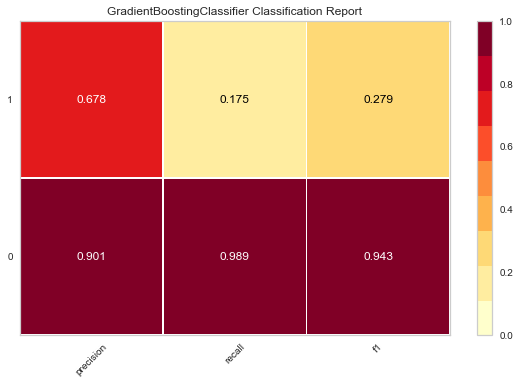

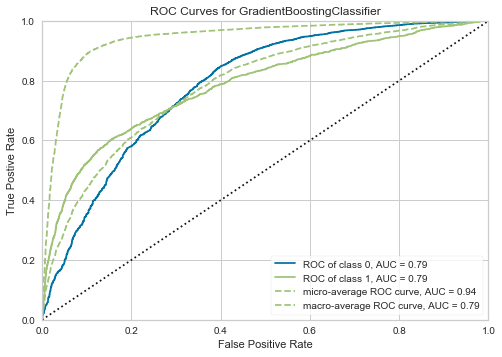

In [60]:
viz = ClassificationReport(gbcl)
viz.fit(X_train, Y_train)
viz.score(X_test, Y_test)
viz.show()

roc = ROCAUC(gbcl)
roc.fit(X_train, Y_train)
roc.score(X_test, Y_test)
roc.show()

## Random Forrest Classifier

In [61]:
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1, max_features=12)
rfcl = rfcl.fit(X_train, Y_train)

In [62]:
RandomForrest = [
    'RandomForrest',
    accuracy_score(Y_test, rfcl.predict(X_test)),
    precision_score(Y_test, rfcl.predict(X_test)),
    recall_score(Y_test, rfcl.predict(X_test)),
    f1_score(Y_test, rfcl.predict(X_test))
]

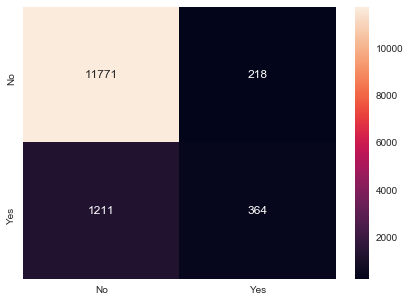

In [63]:
Y_predicted = rfcl.predict(X_test)
cm = confusion_matrix(Y_test, Y_predicted, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

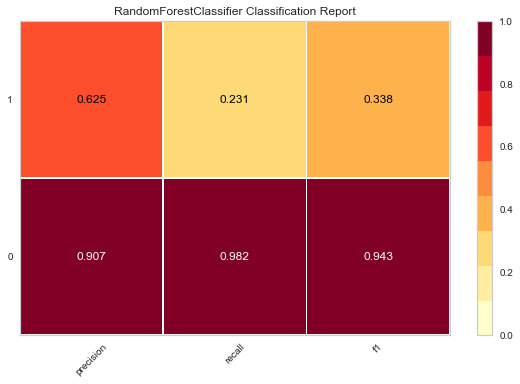

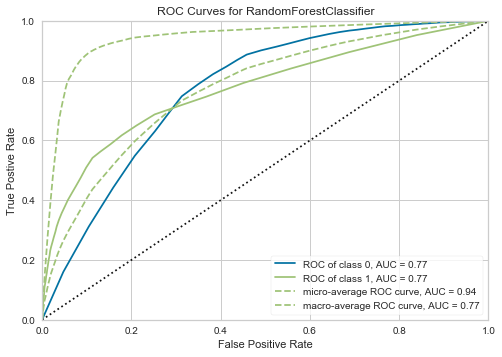

In [64]:
viz = ClassificationReport(rfcl)
viz.fit(X_train, Y_train)
viz.score(X_test, Y_test)
viz.show()

roc = ROCAUC(rfcl)
roc.fit(X_train, Y_train)
roc.score(X_test, Y_test)
roc.show()

In [65]:
Tree

['DecisionTree',
 0.8291064582718962,
 0.2890403180011357,
 0.32317460317460317,
 0.3051558752997602]

In [66]:
mm = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
mm.loc[0] = Tree
mm.loc[1] = Bagging
mm.loc[2] = AdaBoost
mm.loc[3] = GradientBoost
mm.loc[4] = RandomForrest
mm.loc[5] = LogisticRegression

In [67]:
mm

,model,accuracy,precision,recall,f1
0,DecisionTree,0.829106,0.289040,0.323175,0.305156
1,Bagging,0.892510,0.589862,0.243810,0.345013
2,AdaBoost,0.894648,0.659389,0.191746,0.297098
3,GradientBoost,0.894574,0.678133,0.175238,0.278507
4,RandomForrest,0.894648,0.625430,0.231111,0.337506
5,LogisticRegression,0.894058,0.675127,0.168889,0.270188


## Model Comparison

For our problem statement, we will mainly focus on the Precision metric of each model since what we care about the most if reducing the ammounts of False Positives in our predictions. From our metrics table, we see that GradientBoosting and Logistic Regression show the highest levels for precision, as well as similar values for accuracy, recall and F1. When we look at the ROC curve values: Logistic Regression has an AUC of 0.75 and Gradient Boosting has an AUC of 0.79, making Gradient Boosting the better model of the two. 